In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
from sklearn.metrics import confusion_matrix as conmat, f1_score
from pprint import pprint

In [2]:
imgs, labels = list(), list()

for i in range(2):
    for j in range(2):
        for k in range(12):
            for l in range(2):
                S = "{}_{}_{}_{}".format(i,j,k,l)
                files = glob("../../assignment1/q1/images/{}/*.jpg".format(S))
                for file in files:
                    imgs.append(cv2.imread(file))
                    labels.append([i,j,k,l])

imgs = np.array(imgs, dtype=float)/255.0
labels = np.array(labels, dtype=int)

# np.save("../imgs.npy",imgs)
# np.save("../labels.npy",labels)

In [3]:
# imgs, labels = np.load("../imgs.npy"), np.load("../labels.npy")

In [4]:
def shuffle(a,b):
    indices = np.arange(a.shape[0])
    np.random.shuffle(indices)
    a = a[indices]
    b = b[indices]
    return a,b

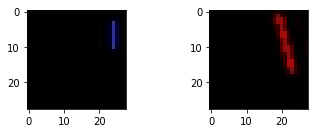

[0 0 6 0] [1 1 7 1]


In [5]:
imgs, labels = shuffle(imgs,labels)
imgstr, labelstr = imgs[:76000], labels[:76000]
imgste, labelste = imgs[76000:], labels[76000:]
plt.subplot(2,2,1)
plt.imshow(imgstr[-1])
plt.subplot(2,2,2)
plt.imshow(imgste[-1])
plt.show()
print(labelstr[-1], labelste[-1])

In [6]:
#this function is useful in order to delete old graphs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [7]:
# one hot encoding
def onehot(classes, tensor):
    N = tensor.shape[0]
    a = np.zeros((N, classes), dtype=int)
    for i,t in enumerate(tensor):
        a[i][t] = 1
    return a

In [8]:
anglestr = onehot(12, labelstr[:,2])
angleste = onehot(12, labelste[:,2])
print (labelstr[-1], anglestr[-1])
print (labelste[-1], angleste[-1])
print(imgstr.shape, anglestr.shape)

[0 0 6 0] [0 0 0 0 0 0 1 0 0 0 0 0]
[1 1 7 1] [0 0 0 0 0 0 0 1 0 0 0 0]
(76000, 28, 28, 3) (76000, 12)


In [9]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, 28, 28, 3], name="X")
    y0 = tf.placeholder(tf.float32, shape=[None], name="y0")
    y1 = tf.placeholder(tf.float32, shape=[None], name="y1")
    y2 = tf.placeholder(tf.float32, shape=[None], name="y2")
    y3 = tf.placeholder(tf.float32, shape=[None, 12], name="y3")
    
conv1_filters=6
conv2_filters=8

conv1 = tf.layers.conv2d(X, filters=conv1_filters, kernel_size=5, padding='SAME', activation=tf.nn.relu)
pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
conv2 = tf.layers.conv2d(pool1, filters=conv2_filters, kernel_size=5, padding='SAME', activation=tf.nn.relu)
pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
flat = tf.reshape(pool2, shape=[-1, np.prod([v.value for v in pool2.shape[1:]])])

# first head for length
fc10 = tf.layers.dense(flat, 32, activation=tf.nn.relu)
fc20 = tf.layers.dense(fc10, 1)
fc20_r = tf.reshape(fc20, shape=[-1])
y0_ = tf.nn.sigmoid(fc20)
xentropy0 = tf.nn.sigmoid_cross_entropy_with_logits(labels=y0, logits=fc20_r)
loss0 = tf.reduce_mean(xentropy0)
correct0 = tf.cast(tf.equal(tf.reshape(tf.round(y0_),shape=[-1]),y0),tf.int32)

# second head for width
fc11 = tf.layers.dense(flat, 32, activation=tf.nn.relu)
fc21 = tf.layers.dense(fc11, 1)
fc21_r = tf.reshape(fc21, shape=[-1])
y1_ = tf.nn.sigmoid(fc21)
xentropy1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=y1, logits=fc21_r)
loss1 = tf.reduce_mean(xentropy1)
correct1 = tf.cast(tf.equal(tf.reshape(tf.round(y1_),shape=[-1]),y1),tf.int32)

# third head for color
fc12 = tf.layers.dense(flat, 32, activation=tf.nn.relu)
fc22 = tf.layers.dense(fc12, 1)
fc22_r = tf.reshape(fc22, shape=[-1])
y2_ = tf.nn.sigmoid(fc22)
xentropy2 = tf.nn.sigmoid_cross_entropy_with_logits(labels=y2, logits=fc22_r)
loss2 = tf.reduce_mean(xentropy2)
correct2 = tf.cast(tf.equal(tf.reshape(tf.round(y2_),shape=[-1]),y2),tf.int32)

# fourth head for angle
fc13 = tf.layers.dense(flat, 128, activation=tf.nn.relu)
fc23 = tf.layers.dense(fc13, 12)
y3_ = tf.nn.softmax(fc23)
xentropy3 = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=fc23, labels=tf.argmax(y3,1))
loss3 = tf.reduce_mean(xentropy3)
correct3 = tf.cast(tf.nn.in_top_k(y3_,tf.argmax(y3,1),1), tf.int32)

# overall loss is sum of all losses
loss = loss0+loss1+loss2+loss3

# backpropagate on loss
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

# a prediction is correct only if all heads predict correct labels
correct = tf.cast((correct0+correct1+correct2+correct3)/4, tf.int32)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

initer = tf.global_variables_initializer()
saver = tf.train.Saver()


In [10]:
epochs = 16
batch_size = 1000

In [11]:
accur_list = np.zeros((epochs,), dtype=float)
loss_list = np.zeros((epochs,), dtype=float)

with tf.Session() as sess:
    initer.run()
    for epoch in range(epochs):
        imgstr, labelstr = shuffle(imgstr,labelstr)
        anglestr = onehot(12, labelstr[:,2])
        for i in range(int(76000/batch_size)):
            X_batch = imgstr[i*batch_size:(i+1)*batch_size]
            y0_batch = labelstr[:,0][i*batch_size:(i+1)*batch_size]
            y1_batch = labelstr[:,1][i*batch_size:(i+1)*batch_size]
            y2_batch = labelstr[:,3][i*batch_size:(i+1)*batch_size]
            y3_batch = anglestr[i*batch_size:(i+1)*batch_size]
            tmp,_ = sess.run((loss,training_op), feed_dict = {X:X_batch, y3:y3_batch, y0:y0_batch, y1:y1_batch, y2:y2_batch})
            loss_list[epoch] += tmp
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y3:y3_batch, y0:y0_batch, y1:y1_batch, y2:y2_batch})
        acc_test = accuracy.eval(feed_dict={X:imgste, y3:angleste, y0:labelste[:,0], y1:labelste[:,1], y2:labelste[:,3]})
        accur_list[epoch] = acc_test
        print("Epoch:",epoch+1, "Loss:", loss_list[epoch], "Train accuracy:", acc_train, "test accuracy:", acc_test)
    out0, out1, out2, out3 = sess.run((y0_,y1_,y2_,y3_), feed_dict={X:imgste, y3:angleste, y0:labelste[:,0], y1:labelste[:,1], y2:labelste[:,3]})

Epoch: 1 Loss: 251.95821261405945 Train accuracy: 0.494 test accuracy: 0.49385
Epoch: 2 Loss: 79.21255105733871 Train accuracy: 0.819 test accuracy: 0.8076
Epoch: 3 Loss: 37.713820695877075 Train accuracy: 0.905 test accuracy: 0.89725
Epoch: 4 Loss: 24.487210363149643 Train accuracy: 0.945 test accuracy: 0.9263
Epoch: 5 Loss: 17.275988772511482 Train accuracy: 0.962 test accuracy: 0.96065
Epoch: 6 Loss: 12.76949817687273 Train accuracy: 0.981 test accuracy: 0.96995
Epoch: 7 Loss: 9.534502699971199 Train accuracy: 0.985 test accuracy: 0.98345
Epoch: 8 Loss: 10.059185281395912 Train accuracy: 0.994 test accuracy: 0.9862
Epoch: 9 Loss: 6.775911405682564 Train accuracy: 0.993 test accuracy: 0.98985
Epoch: 10 Loss: 5.558093775063753 Train accuracy: 0.997 test accuracy: 0.99435
Epoch: 11 Loss: 4.6505513824522495 Train accuracy: 0.998 test accuracy: 0.9941
Epoch: 12 Loss: 3.976984079927206 Train accuracy: 0.997 test accuracy: 0.9953
Epoch: 13 Loss: 3.3473887778818607 Train accuracy: 0.995 tes

-----Loss-----


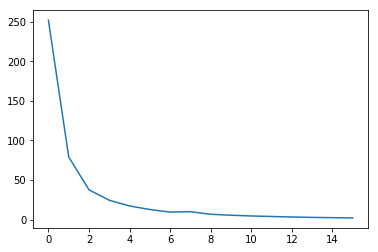

In [12]:
print("-----Loss-----")
plt.plot(loss_list)
plt.show()

-----Accuracy-----


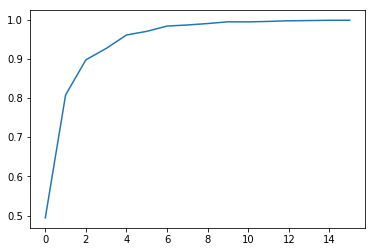

In [13]:
print("-----Accuracy-----")
plt.plot(accur_list)
plt.show()

In [14]:
cm0 = conmat(labelste[:,0],np.around(out0.flatten()))
print("Confusion matrix for HEAD 0 (length)\n")
print(cm0)
f0 = f1_score(labelste[:,0], np.around(out0.flatten()), average=None)
print("\nF-Score :\n", f0)

Confusion matrix for HEAD 0 (length)

[[ 9949     0]
 [    0 10051]]

F-Score :
 [1. 1.]


In [15]:
cm1 = conmat(labelste[:,1],np.around(out1.flatten()))
print("Confusion matrix for HEAD 1 (width)\n")
print(cm1)
f1 = f1_score(labelste[:,1], np.around(out1.flatten()), average=None)
print("\nF-Score :\n", f1)

Confusion matrix for HEAD 1 (width)

[[ 9999     0]
 [    0 10001]]

F-Score :
 [1. 1.]


In [16]:
cm2 = conmat(labelste[:,3],np.around(out2.flatten()))
print("Confusion matrix for HEAD 2 (color)\n")
print(cm2)
f2 = f1_score(labelste[:,3],np.around(out2.flatten()), average=None)
print("\nF-Score :\n", f2)

Confusion matrix for HEAD 2 (color)

[[10079     0]
 [    0  9921]]

F-Score :
 [1. 1.]


In [18]:
cm3 = conmat(labelste[:,2],np.argmax(out3, 1))
print("Confusion matrix for HEAD 3 (angle)\n")
print(cm3)
f3 = f1_score(labelste[:,2],np.argmax(out3, 1), average=None)
print("\nF-Score :\n", f3)

Confusion matrix for HEAD 3 (angle)

[[1713    0    0    0    0    0    0    0    0    0    0    0]
 [   2 1676    8    0    0    0    0    0    0    0    0    0]
 [   0    0 1646    0    0    0    0    0    0    0    0    0]
 [   0    0    4 1642    6    0    0    0    0    0    0    0]
 [   0    0    0    0 1670    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1616    0    0    0    0    0    0]
 [   0    0    0    0    0    1 1603    0    0    0    0    0]
 [   0    0    0    0    0    0    0 1688    0    0    0    0]
 [   0    0    0    0    0    0    0    1 1705    1    0    0]
 [   0    0    0    0    0    0    0    0    4 1664    0    0]
 [   0    0    0    0    0    0    0    0    0    0 1676    0]
 [   7    0    0    0    0    0    0    0    0    0    0 1667]]

F-Score :
 [0.99737991 0.99702558 0.99636804 0.99696418 0.99820681 0.99969069
 0.99968818 0.99970388 0.99824356 0.99849985 1.         0.99790482]
